# Gaming Industry: Sales Drivers for Games

### Group Assignment - Team 7

Cime Ajouz<br>James Janovsky<br>Rashmi Francis<br>Victor Fonseca

 _University of Toronto_

##### Libraries

In [1]:
from bs4 import BeautifulSoup 
import pandas as pd 
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## PART 1 - COMPLETING THE DATASET

##### Reading Kaggle file

In [5]:
games = pd.read_csv("vgsales.csv", dtype = {"Year" : "Int64"})
# games["Name"] = games["Name"].str.lower()
games.loc[(games["Name"].str.find('(') >= 0), "Name"] = \
        games[games["Name"].str.find('(') >= 0]["Name"].str.split('(', expand=True)[0].str.strip()
games["Name"] = games["Name"].str.replace("&", "and")
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
Rank            16598 non-null int64
Name            16598 non-null object
Platform        16598 non-null object
Year            16327 non-null Int64
Genre           16598 non-null object
Publisher       16540 non-null object
NA_Sales        16598 non-null float64
EU_Sales        16598 non-null float64
JP_Sales        16598 non-null float64
Other_Sales     16598 non-null float64
Global_Sales    16598 non-null float64
dtypes: Int64(1), float64(5), int64(1), object(4)
memory usage: 1.4+ MB


In [7]:
games = games.groupby(['Name', 'Platform', 'Year', 'Genre', 'Publisher']).agg({"NA_Sales":"sum","EU_Sales":"sum","JP_Sales":"sum","Other_Sales":"sum","Global_Sales":"sum"}).reset_index()
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16290 entries, 0 to 16289
Data columns (total 10 columns):
Name            16290 non-null object
Platform        16290 non-null object
Year            16290 non-null int64
Genre           16290 non-null object
Publisher       16290 non-null object
NA_Sales        16290 non-null float64
EU_Sales        16290 non-null float64
JP_Sales        16290 non-null float64
Other_Sales     16290 non-null float64
Global_Sales    16290 non-null float64
dtypes: float64(5), int64(1), object(4)
memory usage: 1.2+ MB


##### API procedure for enriching dataset with new variables

In [52]:
# Defining funtion for searching game on RAWG API by the name declared on the core dataset

def game_API(name):
    url = f"https://api.rawg.io/api/games?page_size=1&search={name}"
    game_search = requests.get(url)
    soup = BeautifulSoup(game_search.content, "lxml")
    game_data = json.loads(soup.text)
    game_release_date = game_data["results"][0]['released'] # Date when the game was released
    game_playtime = game_data["results"][0]['playtime'] # Game playtime
    game_rating = game_data["results"][0]['rating'] # Game rating, according to RAWG users
    game_n_platforms = len(game_data["results"][0]['platforms']) # Total number of platforms for which the game is licensed
    game_search_name = game_data["results"][0]['name'] # Name of the game found on the API
    return(game_release_date,game_playtime,game_rating,game_n_platforms,game_search_name)

In [ ]:
# Running a loop for executing the function for each game in the core dataset

for i in range(games.shape[0]):
    try:
        game_data = game_API(games.loc[i,"Name"])
        games.loc[i,"API_release_date"] = game_data[0]
        games.loc[i,"API_playtime"] = game_data[1]
        games.loc[i,"API_rating"] = game_data[2]
        games.loc[i,"API_n_platforms"] = game_data[3]
        games.loc[i,"API_search_name"] = game_data[4]
    except:
        print("error on",i) # for games not found, print an error message
    if (i%100 == 0):
        print (i, "done")
games.shape

##### Save enriched dataset to CSV file 

In [ ]:
games.to_csv(r'games_complete_5.csv', index=False)

## PART 2 - DATA PREPARATION

##### Reading complete file and calculating Levenshtein distance 

In [76]:
games_prep = pd.read_csv("games_complete_5.csv")
games_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16199 entries, 0 to 16198
Data columns (total 15 columns):
Name                16199 non-null object
Platform            16199 non-null object
Year                16199 non-null int64
Genre               16199 non-null object
Publisher           16199 non-null object
NA_Sales            16199 non-null float64
EU_Sales            16199 non-null float64
JP_Sales            16199 non-null float64
Other_Sales         16199 non-null float64
Global_Sales        16199 non-null float64
API_release_date    15365 non-null object
API_playtime        16160 non-null float64
API_rating          16160 non-null float64
API_n_platforms     16160 non-null float64
API_search_name     16160 non-null object
dtypes: float64(8), int64(1), object(6)
memory usage: 1.9+ MB


In [77]:
# Macro for calculating the Levenshtein distance

import numpy as np
def levenshtein_ratio_and_distance(s, t, ratio_calc = True):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        return "The strings are {} edits away".format(distance[row][col])

In [78]:
# Preparing the names for calculating the Levenshtein distance

games_prep.loc[games_prep["API_search_name"].isna()==True, "API_search_name"] = "Not found"
games_prep["lower_Name"] = games_prep["Name"].str.lower()
games_prep["lower_API_search_name"] = games_prep["API_search_name"].str.lower()

In [79]:
# Calculating the Levenshtein distance for comparing the lowered original game name  
# to the lowered game name found on the API

games_prep["levenshtein"] = games_prep.apply(lambda x:levenshtein_ratio_and_distance(x["lower_Name"],x["lower_API_search_name"]),axis=1)
games_prep["levenshtein"].describe()

count    16199.000000
mean         0.867832
std          0.219248
min          0.000000
25%          0.786701
50%          1.000000
75%          1.000000
max          1.000000
Name: levenshtein, dtype: float64

12056
11644
11270
10723


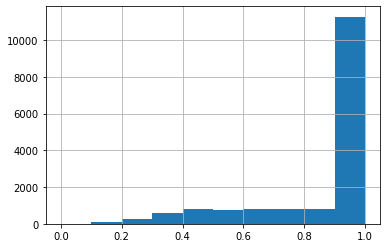

In [80]:
games_prep["levenshtein"].hist()
print(sum(games_prep["levenshtein"]>=0.8))
print(sum(games_prep["levenshtein"]>=0.85))
print(sum(games_prep["levenshtein"]>=0.9))
print(sum(games_prep["levenshtein"]>=0.95))

In [81]:
games_prep.loc[(games_prep["Name"].str.find('(') >= 0), "Name"] 

1025                Battlefield 2: Modern Combat(JP sales)
2077     Chou-Kuukan Night Pro Yakyuu King(higher JP sa...
7328        Lunar 2: Eternal Blue(sales, but wrong system)
10636                             Puyo Pop Fever(us sales)
10773                       RalliSport Challenge(JP sales)
11731                         Secret Agent Clank(US sales)
14739                          TouchMaster 3(Others sales)
Name: Name, dtype: object

In [82]:
games_prep[games_prep["Name"].str.find('(') >= 0]["Name"].str.split('(', expand=True)[0].str.strip()

1025          Battlefield 2: Modern Combat
2077     Chou-Kuukan Night Pro Yakyuu King
7328                 Lunar 2: Eternal Blue
10636                       Puyo Pop Fever
10773                 RalliSport Challenge
11731                   Secret Agent Clank
14739                        TouchMaster 3
Name: 0, dtype: object

In [83]:
# Fixing manually records with partial sales that were not eliminated by the previous aggregation
games_prep.loc[1022, "JP_Sales"] = 0.02
games_prep.loc[2076, "JP_Sales"] = 0.41
games_prep.loc[10633, "NA_Sales"] = 0.03
games_prep.loc[10771, "JP_Sales"] = 0.01
games_prep.loc[11730, "NA_Sales"] = 0.37
games_prep.loc[11730, "EU_Sales"] = 0.25
games_prep.loc[14738, "EU_Sales"] = 0.35
games_prep.loc[14738, "Other_Sales"] = 0.06
# Dropping records with unnecessary information
games_prep = games_prep.drop([games_prep.index[1025],
                              games_prep.index[2077],
                              games_prep.index[7328],
                              games_prep.index[10636],
                              games_prep.index[10773],
                              games_prep.index[11731],
                              games_prep.index[14739]])
games_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16192 entries, 0 to 16198
Data columns (total 18 columns):
Name                     16192 non-null object
Platform                 16192 non-null object
Year                     16192 non-null int64
Genre                    16192 non-null object
Publisher                16192 non-null object
NA_Sales                 16192 non-null float64
EU_Sales                 16192 non-null float64
JP_Sales                 16192 non-null float64
Other_Sales              16192 non-null float64
Global_Sales             16192 non-null float64
API_release_date         15358 non-null object
API_playtime             16153 non-null float64
API_rating               16153 non-null float64
API_n_platforms          16153 non-null float64
API_search_name          16192 non-null object
lower_Name               16192 non-null object
lower_API_search_name    16192 non-null object
levenshtein              16192 non-null float64
dtypes: float64(9), int64(1), object(

In [109]:
# Deleting information from games mismatched in the API search
games_prep = games_prep[games_prep["Year"]<2017]
games_prep.loc[games_prep["levenshtein"]<0.85, ['API_release_date','API_playtime','API_rating',
                                            'API_n_platforms','API_search_name']] = np.nan
games_prep[games_prep["levenshtein"]<0.85][["Name","API_search_name","levenshtein"]]

,Name,API_search_name,levenshtein
0,'98 Koshien,NaN,0.266667
8,.hack//Quarantine Part 4: The Final Chapter,NaN,0.716418
9,.hack: Sekai no Mukou ni + Versus,NaN,0.810127
11,007: Quantum of Solace,NaN,0.800000
12,007: Quantum of Solace,NaN,0.800000
...,...,...,...
16163,[Prototype 2],NaN,0.818182
16173,everGirl,NaN,0.500000
16191,th!nk Logic Trainer,NaN,0.230769
16194,thinkSMART: Chess for Kids,NaN,0.266667


In [110]:
# Recoding the Platform names to the complete names
games_prep.loc[games_prep["Platform"]=='DS', "Platform"] = 'Nintendo DS'
games_prep.loc[games_prep["Platform"]=='PS2', "Platform"] = 'Playstation 2'
games_prep.loc[games_prep["Platform"]=='PS3', "Platform"] = 'Playstation 3'
games_prep.loc[games_prep["Platform"]=='Wii', "Platform"] = 'Nintendo Wii'
games_prep.loc[games_prep["Platform"]=='X360', "Platform"] = 'Xbox 360'
games_prep.loc[games_prep["Platform"]=='PS', "Platform"] = 'Playstation'
games_prep.loc[games_prep["Platform"]=='PSP', "Platform"] = 'Playstation Portable'
games_prep.loc[games_prep["Platform"]=='PC', "Platform"] = 'PC Engine'
games_prep.loc[games_prep["Platform"]=='XB', "Platform"] = 'Xbox'
games_prep.loc[games_prep["Platform"]=='GBA', "Platform"] = 'Game Boy Advance'
games_prep.loc[games_prep["Platform"]=='3DS', "Platform"] = '3DS'
games_prep.loc[games_prep["Platform"]=='PSV', "Platform"] = 'Playstation Vita'
games_prep.loc[games_prep["Platform"]=='PS4', "Platform"] = 'Playstation 4'
games_prep.loc[games_prep["Platform"]=='N64', "Platform"] = 'Nintendo 64'
games_prep.loc[games_prep["Platform"]=='SNES', "Platform"] = 'Super NES/Super Famicon'
games_prep.loc[games_prep["Platform"]=='XOne', "Platform"] = 'Xbox One'
games_prep.loc[games_prep["Platform"]=='SAT', "Platform"] = 'Saturn'
games_prep.loc[games_prep["Platform"]=='WiiU', "Platform"] = 'Nintendo Wii U'
games_prep.loc[games_prep["Platform"]=='2600', "Platform"] = 'Atari 2600'
games_prep.loc[games_prep["Platform"]=='NES', "Platform"] = 'NES/Famicon'
games_prep.loc[games_prep["Platform"]=='GB', "Platform"] = 'Game Boy'
games_prep.loc[games_prep["Platform"]=='DC', "Platform"] = 'Dreamcast'
games_prep.loc[games_prep["Platform"]=='GEN', "Platform"] = 'Genesis'
games_prep.loc[games_prep["Platform"]=='NG', "Platform"] = 'Neo Geo'
games_prep.loc[games_prep["Platform"]=='SCD', "Platform"] = 'Sega CD'
games_prep.loc[games_prep["Platform"]=='WS', "Platform"] = 'WonderSwan'
games_prep.loc[games_prep["Platform"]=='3DO', "Platform"] = '3DO'
games_prep.loc[games_prep["Platform"]=='TG16', "Platform"] = 'TurboGrafx-16'
games_prep.loc[games_prep["Platform"]=='PCFX', "Platform"] = 'PC-FX'
games_prep.loc[games_prep["Platform"]=='GG', "Platform"] = 'Game Gear'
games_prep.loc[games_prep["Platform"]=='GC', "Platform"] = 'Game Cube'
games_prep["Platform"].value_counts()

Nintendo DS      2099
Playstation 2    2096
Playstation 3    1302
Nintendo Wii     1285
Xbox 360         1230
                 ... 
Sega CD             6
3DO                 3
TurboGrafx-16       2
Game Gear           1
PC-FX               1
Name: Platform, Length: 31, dtype: int64

In [ ]:
games_prep = games_prep.drop(['lower_Name','lower_API_search_name'], axis=1)
games_prep.columns

In [112]:
games_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16188 entries, 0 to 16198
Data columns (total 16 columns):
Name                16188 non-null object
Platform            16188 non-null object
Year                16188 non-null int64
Genre               16188 non-null object
Publisher           16188 non-null object
NA_Sales            16188 non-null float64
EU_Sales            16188 non-null float64
JP_Sales            16188 non-null float64
Other_Sales         16188 non-null float64
Global_Sales        16188 non-null float64
API_release_date    11128 non-null object
API_playtime        11642 non-null float64
API_rating          11642 non-null float64
API_n_platforms     11642 non-null float64
API_search_name     11642 non-null object
levenshtein         16188 non-null float64
dtypes: float64(9), int64(1), object(6)
memory usage: 2.1+ MB


##### Saving file to CSV

In [113]:
games_prep.to_csv(r'games_complete_5_levenshtein.csv', index=False)

## PART 3 - EXPLORATORY ANALYSIS

In [2]:
games = pd.read_csv("games_complete_5_levenshtein.csv")
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16188 entries, 0 to 16187
Data columns (total 16 columns):
Name                16188 non-null object
Platform            16188 non-null object
Year                16188 non-null int64
Genre               16188 non-null object
Publisher           16188 non-null object
NA_Sales            16188 non-null float64
EU_Sales            16188 non-null float64
JP_Sales            16188 non-null float64
Other_Sales         16188 non-null float64
Global_Sales        16188 non-null float64
API_release_date    11128 non-null object
API_playtime        11642 non-null float64
API_rating          11642 non-null float64
API_n_platforms     11642 non-null float64
API_search_name     11642 non-null object
levenshtein         16188 non-null float64
dtypes: float64(9), int64(1), object(6)
memory usage: 2.0+ MB


In [115]:
sum(games["levenshtein"]>0.85)

11639

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000012E0889A8C8>]],
      dtype=object)

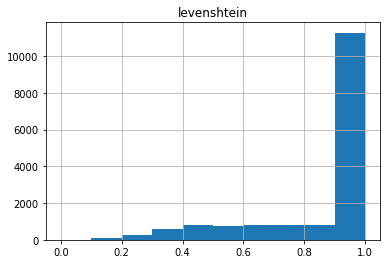

In [98]:
games.hist("levenshtein")

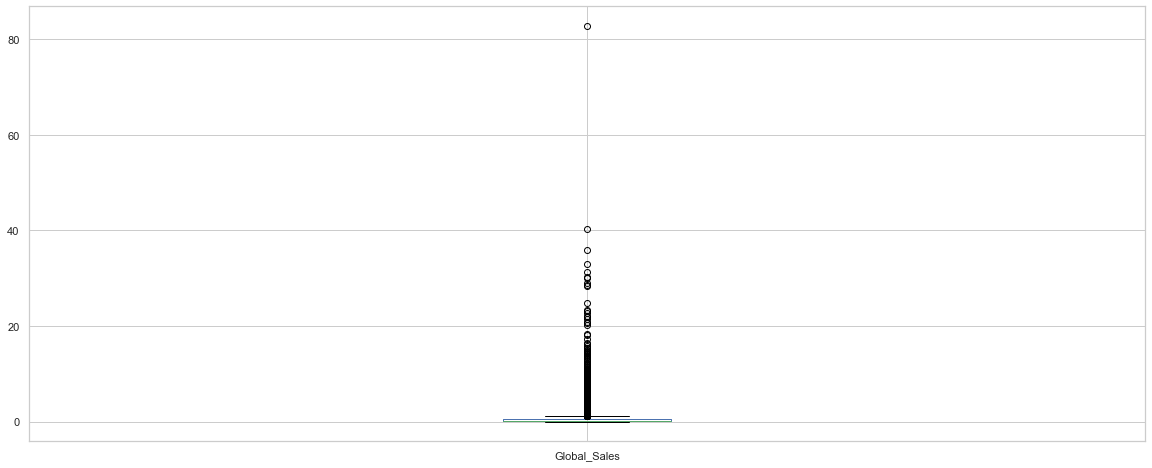

In [123]:
games.boxplot("Global_Sales")

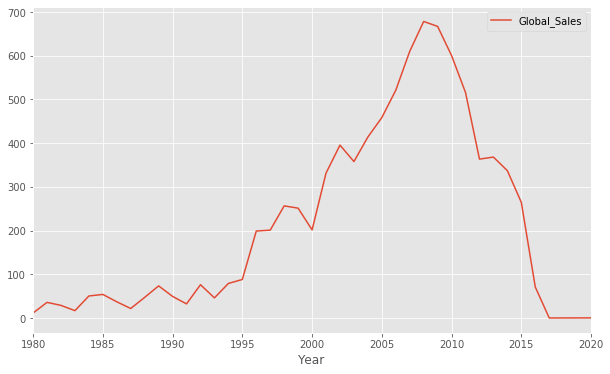

In [107]:
global_sales = games.groupby("Year").agg({"Global_Sales":"sum"})
plt = global_sales.plot()
plt

Text(0.5, 1.0, 'CHART 1 - Yearly Sales by Market')

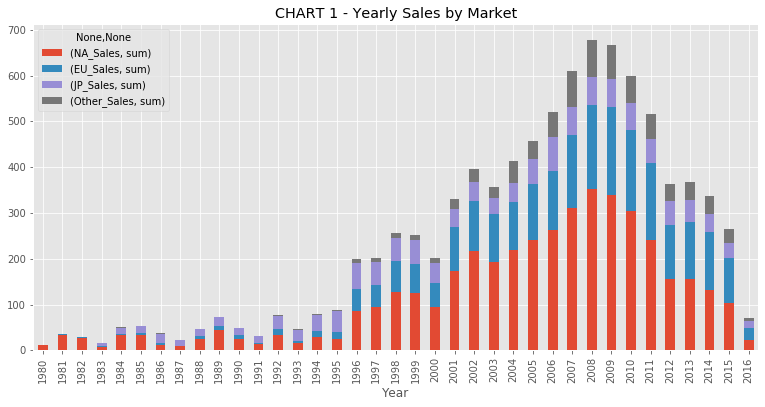

In [118]:
games.groupby('Year')[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']] \
            .agg(['sum']).plot.bar(stacked=True, figsize=(13,6)) \
            .set_title("CHART 1 - Yearly Sales by Market")

In [48]:
teste = games.groupby(['Platform','Genre'])\
    .agg({"NA_Sales":"sum", \
          "EU_Sales":["sum"],
          "JP_Sales":["sum"],
          "Other_Sales":["sum"],
          "Global_Sales":["sum"],}) \
    .sort_values(by=(('Global_Sales',   'sum')), ascending=False)
teste.to_excel("table3.xlsx")

In [127]:
games.groupby("Genre").agg({"Global_Sales":["count","mean","sum"]}).sort_values(by=('Global_Sales','sum'), ascending=False)

Global_Sales                   
                    count      mean      sum
Genre                                       
Action               3235  0.532563  1722.84
Sports               2289  0.535824  1226.50
Shooter              1280  0.801719  1026.20
Role-Playing         1448  0.638004   923.83
Platform              872  0.950837   829.13
Misc                 1679  0.470441   789.87
Racing               1224  0.593758   726.76
Fighting              825  0.538242   444.05
Simulation            841  0.463710   389.98
Puzzle                566  0.427933   242.21
Adventure            1271  0.184571   234.59
Strategy              668  0.259386   173.27

In [100]:
games.groupby("Publisher").agg({"Global_Sales":["count","mean","sum"]}).sort_values(by=('Global_Sales','sum'), ascending=False).head(20)

Global_Sales                   
                                              count      mean      sum
Publisher                                                             
Nintendo                                        689  2.589884  1784.43
Electronic Arts                                1330  0.822083  1093.37
Activision                                      964  0.748351   721.41
Sony Computer Entertainment                     674  0.900193   606.73
Ubisoft                                         912  0.519232   473.54
Take-Two Interactive                            412  0.969175   399.30
THQ                                             709  0.480169   340.44
Konami Digital Entertainment                    811  0.343477   278.56
Sega                                            630  0.429683   270.70
Namco Bandai Games                              919  0.276007   253.65
Microsoft Game Studios                          188  1.307340   245.78
Capcom                                          375  0.533200   199.95
Atari                                           344  0.426657   146.77
Square Enix                                     230  0.629261   144.73
Warner Bros. Interactive Entertainment          216  0.657778   142.08
Disney Interactive Studios                      214  0.554953   118.76
Eidos Interactive                               196  0.493622    96.75
LucasArts                                        89  0.954494    84.95
Bethesda Softworks                               69  1.181594    81.53
Midway Games                                    196  0.353520    69.29

In [103]:
pivot_sales = games.groupby(["Platform","Genre"]).agg({"Global_Sales":"sum"}).sort_values(by='Global_Sales', ascending=False)
pivot_sales = pd.pivot_table(pivot_sales, values='Global_Sales', index='Platform', columns='Genre', aggfunc=np.sum).fillna(0)
pivot_sales

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Platform,,,,,,,,,,,,
3DO,0.00,0.06,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.00
3DS,56.61,4.73,10.46,10.48,32.23,5.56,14.41,75.71,1.22,26.59,6.18,2.09
Atari 2600,26.39,0.40,0.77,3.58,13.27,13.65,2.32,0.00,22.97,0.45,2.77,0.00
Dreamcast,1.26,2.50,1.83,0.00,2.54,0.00,2.65,0.68,0.33,0.52,3.66,0.00
Game Boy,7.92,17.16,0.00,13.35,53.88,47.47,4.55,88.24,1.20,3.55,9.05,8.05
Game Boy Advance,54.26,12.10,4.21,28.50,78.08,12.09,18.80,64.21,3.60,5.91,16.41,7.45
Game Cube,37.25,5.93,18.43,16.45,28.66,4.57,21.79,13.03,13.63,8.59,24.49,4.32
Game Gear,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Genesis,2.74,0.19,5.90,0.03,15.45,0.00,0.26,0.27,0.13,0.00,3.20,0.19


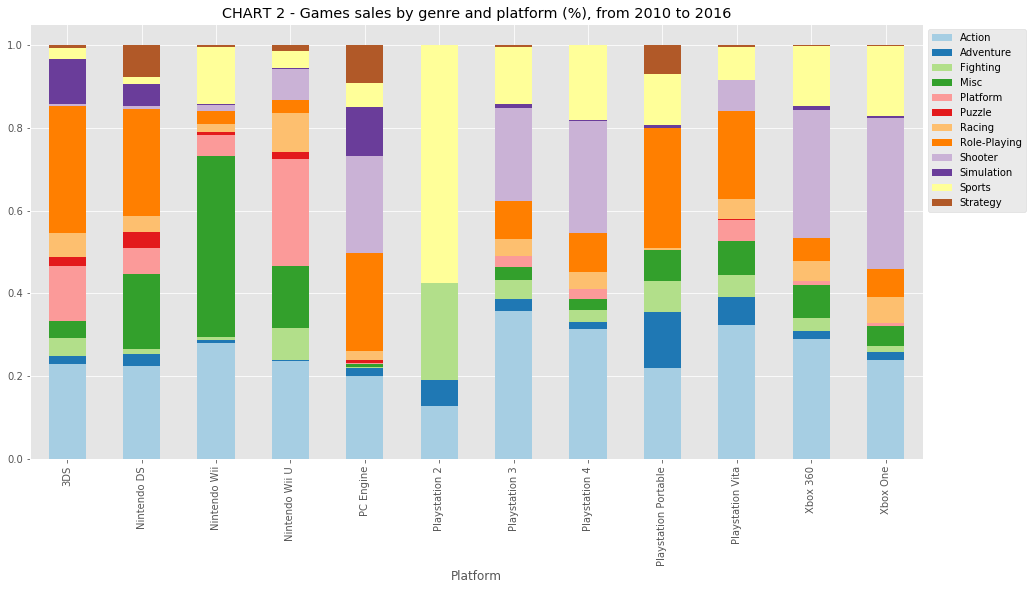

In [23]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4)
pd.options.display.max_rows = 10
plt.style.use(style='ggplot')
from matplotlib.colors import ListedColormap

pivot_sales = games[games['Year']>2010].groupby(["Platform","Genre"]).agg({"Global_Sales":"sum"}).sort_values(by='Global_Sales', ascending=False)
pivot_sales = pd.pivot_table(pivot_sales, values='Global_Sales', index='Platform', columns='Genre', aggfunc=np.sum).fillna(0)
pivot_sales["Total"] = pivot_sales['Action'] + pivot_sales['Adventure'] + pivot_sales['Fighting'] + pivot_sales['Misc'] + pivot_sales['Platform'] + pivot_sales['Puzzle'] + pivot_sales['Racing'] + pivot_sales['Role-Playing'] + pivot_sales['Shooter'] + pivot_sales['Simulation'] + pivot_sales['Sports'] + pivot_sales['Strategy']
pivot_sales.columns
pivot_sales['Action'] = pivot_sales['Action'] / pivot_sales['Total']
pivot_sales['Adventure'] = pivot_sales['Adventure'] / pivot_sales['Total']
pivot_sales['Fighting'] = pivot_sales['Fighting'] / pivot_sales['Total']
pivot_sales['Misc'] = pivot_sales['Misc'] / pivot_sales['Total']
pivot_sales['Platform'] = pivot_sales['Platform'] / pivot_sales['Total']
pivot_sales['Puzzle'] = pivot_sales['Puzzle'] / pivot_sales['Total']
pivot_sales['Racing'] = pivot_sales['Racing'] / pivot_sales['Total']
pivot_sales['Role-Playing'] = pivot_sales['Role-Playing'] / pivot_sales['Total']
pivot_sales['Shooter'] = pivot_sales['Shooter'] / pivot_sales['Total']
pivot_sales['Simulation'] = pivot_sales['Simulation'] / pivot_sales['Total']
pivot_sales['Sports'] = pivot_sales['Sports'] / pivot_sales['Total']
pivot_sales['Strategy'] = pivot_sales['Strategy'] / pivot_sales['Total']
genre_plat = pivot_sales[['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports', 'Strategy']] \
        .plot(kind='bar',stacked=True, figsize=(16,8), colormap=ListedColormap(sns.color_palette("Paired", 12)))
genre_plat.set_title("CHART 2 - Games sales by genre and platform (%), from 2010 to 2016")
genre_plat.legend(bbox_to_anchor=(1, 1))
genre_plat

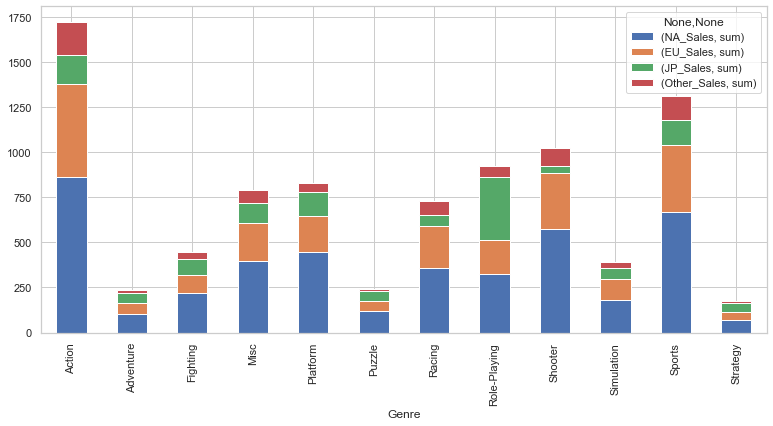

In [123]:
games.groupby('Genre')[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']] \
    .agg(['sum']).plot.bar(stacked=True, figsize=(13,6))

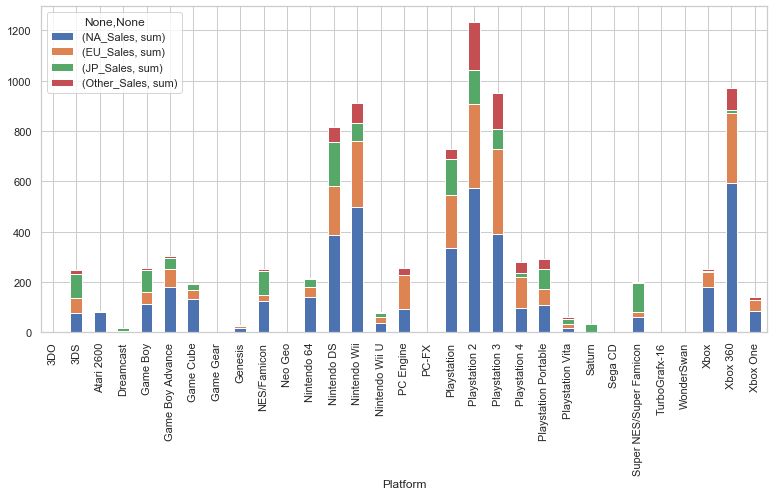

In [124]:
games.groupby('Platform')[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']] \
    .agg(['sum']).plot.bar(stacked=True, figsize=(13,6))

In [37]:
plt.plot?

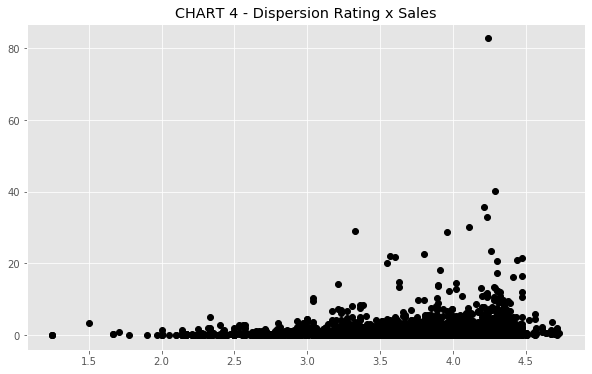

In [39]:
# games.scatter("API_rating", "Global_Sales")
plt.plot(games[games["API_rating"]!=0]["API_rating"], games[games["API_rating"]!=0]["Global_Sales"], 'o', color='black')
plt.title("CHART 4 - Dispersion Rating x Sales")
plt.rc('figure', figsize=(13, 6))

In [26]:
# Correlation matrix - export to Excel
games_rating = games[games["levenshtein"]> 0.85]
games_rating = games_rating[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales','API_playtime','API_rating','API_n_platforms']]
games_rating.corr(method="pearson").to_excel("corr2.xlsx")

Text(0.5, 1.0, 'CHART 3 - Sales by rating')

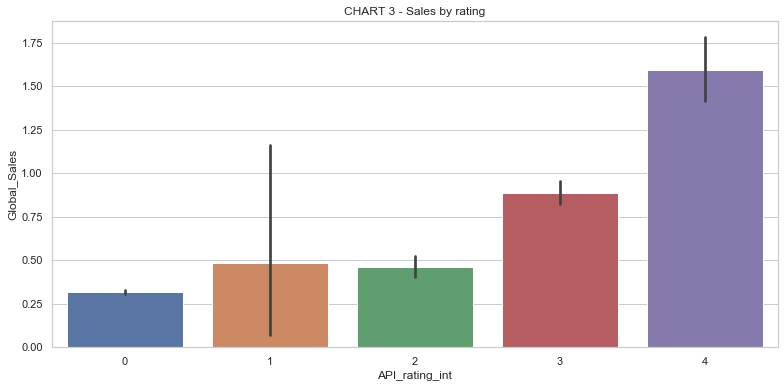

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4)
pd.options.display.max_rows = 10
plt.style.use(style='ggplot')

plt.rc('figure', figsize=(13, 6))
sns.set(style="whitegrid")
games_rating["API_rating"] = games_rating["API_rating"].fillna(0)
games_rating["API_rating_int"] = games_rating["API_rating"].astype('int')
ax = sns.barplot(x=games_rating["API_rating_int"], y=games_rating["Global_Sales"], data=games_rating)
ax.set_title("CHART 3 - Sales by rating")